In [1]:
#importing required libraries

import pandas as pd
import numpy as np
import random
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import glob

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.utils import to_categorical


##### Function to Show Images

In [2]:
def show_images(img1, img2, name):
    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap="gray")
    plt.title('Brain Image with Tumor')
    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap="gray")
    plt.title('Brain Image without Tumor')
    plt.savefig('../images/{}'.format(name))

##### Load Images from Dataset

In [3]:
images_to_show = (33,18)
size_images = 128

#import images function
def import_data():
    def read_images(path):
        return [Image.open(file) for file in glob.glob(path)]
    
    path_yes = 'C:/Users/Windows 10/Project/Brain-Tumor-Detections---Image-Processing/DataSet MRI Images/yes/*'
    path_no = 'C:/Users/Windows 10/Project/Brain-Tumor-Detections---Image-Processing/DataSet MRI Images/no/*'
    
    images_yes = read_images(path_yes)
    images_no = read_images(path_no)
    
    print('Images Imported Complete')
    show_images(images_yes[images_to_show[0]], images_no[images_to_show[1]], '0-raw.png')
    return images_yes, images_no

Images Imported Complete


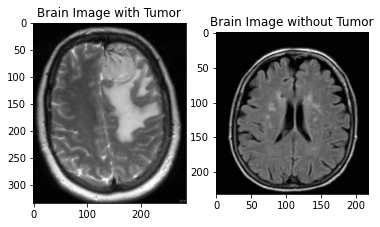

In [4]:
#FunctionCall --> import_data()
images_y, images_n = import_data()

##### Image Preprocessing (Data preparation)

In [5]:
def preparation(images_y, images_n):
    
    '''
    func sqaure_image -->
    1) Squaring image
    2) desired_size: a square whose side is the max between original base and height
    3) create a black image with the desired size
    4) paste the original image in the 'center' of the new image
    '''
    
    def square_image(list_of_images):
        res = []
        for img in list_of_images:
            desired_size = (max(img.size), max(img.size))
            position = int(max(img.size)/2) - int(min(img.size)/2)
            sq_img = Image.new("RGB", desired_size, color='black')
            
            if img.size[0] < img.size[1]:
                sq_img.paste(img, (0, position))
            else:
                sq_img.paste(img, (position,0))
                
            res.append(sq_img)
        return res
    
    #Function call to square_image    
    images_y, images_n = square_image(images_y), square_image(images_n)
    print('Squared Images')
    show_images(images_y[images_to_show[0]], images_n[images_to_show[1]],'1-squared.png')
    
    '''
    func resize_images -->
    Reshape all images to 128x128
    '''
    def resize_images(list_of_images, size=size_images):
        return [img.resize((size, size)) for img in list_of_images]
    
    
    #Function call to resize_image
    images_y, images_n = resize_images(images_y), resize_images(images_n)
    print('Resized Images')
    show_images(images_y[images_to_show[0]], images_n[images_to_show[1]], '2-resized.png')
    
    
    '''
    func image_to_nparray -->
    Convert images to numpy array in order to use open cv library as it doesn't work with images
    '''  
    def image_to_nparray(list_of_images):
        return[np.array(img) for img in list_of_images]
    
    images_y, images_n = image_to_nparray(images_y), image_to_nparray(images_n)
    print('Converted Images as np arrays')
    
    '''
    func image_to_gray_scale -->
    Convert images to gray scale images
    '''
    def images_to_gray_scale(list_of_images):
        return [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in list_of_images]
    
    images_y, images_n = images_to_gray_scale(images_y), images_to_gray_scale(images_n)
    print("Gray Scale Images")
    show_images(images_y[images_to_show[0]], images_n[images_to_show[1]], '3-grayscale.png')
    
    '''
    func median_filter -->
    To apply filter to soften the images
    '''
    def median_filter(list_of_images):
        return [cv2.medianBlur(img,1) for img in list_of_images]
    
    images_y, images_n = median_filter(images_y), median_filter(images_n)
    print("Median Filter Applied to the Images")
    show_images(images_y[images_to_show[0]], images_n[images_to_show[1]], '4-filtered.png')
    
    '''
    func images_to_bandw -->
    To transform list of images to black and white
    Threashold-> 0 is black, 255 is white. so threshold is 127
    above 127 is white and below is black
    '''
    
    def images_to_bandw(list_of_images):
        return [cv2.threshold(img, 127,255, cv2.THRESH_BINARY)[1] for img in list_of_images]
    
    images_y, images_n = images_to_bandw(images_y), images_to_bandw(images_n)
    print("Images transformerd to Black and White")
    show_images(images_y[images_to_show[0]], images_n[images_to_show[1]], '5-BandW.png')
    
    return images_y, images_n

Squared Images
Resized Images


<ipython-input-2-b9a56899442e>:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 1)
<ipython-input-2-b9a56899442e>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 2, 2)


Converted Images as np arrays
Gray Scale Images
Median Filter Applied to the Images
Images transformerd to Black and White


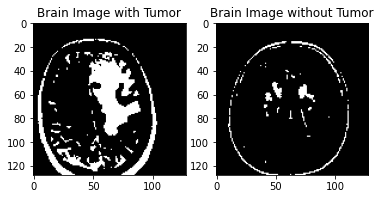

In [6]:
images_y, images_n = preparation(images_y, images_n)

##### Dataframe Preparation by converting np array to dataframes

In [7]:
def dataframe_preparation(images_y, images_n):
    
    '''
    func list_np_to_pd -->
    To convert np array to 1d array and then put it in pandas dataframe
    '''
    def list_np_to_pd(list_of_images):
        return pd.DataFrame([img.flatten() for img in list_of_images])
    
    images_y, images_n = list_np_to_pd(images_y), list_np_to_pd(images_n)
    print('Converted to dataframe')
    
    # Preparation of the dataframe for the Neural Network
    # input images dimentions
    
    img_rows, img_cols = size_images, size_images
    
    df_y = images_y.T
    df_n = images_n.T
    
    num_y = df_y.values.shape[1]
    num_n = df_n.values.shape[1]
    
    yes = df_y.values.reshape(img_rows, img_cols, num_y)
    no = df_n.values.reshape(img_rows, img_cols, num_n)
    X = np.concatenate((yes, no), axis = 2).swapaxes(2,0)
    y = np.concatenate((np.ones(num_y), np.zeros(num_n)))
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 6)
    
    return X_train, X_test, y_train, y_test, img_rows, img_cols
    

In [8]:
X_train, X_test, y_train, y_test, img_rows, img_cols = dataframe_preparation(images_y, images_n)

Converted to dataframe


##### Model Architecture

In [9]:
# Defining the architecture of our model

def neural_network_architecture(X_train, X_test, y_train, y_test, img_rows, img_cols):
    
    # Preparing data to feed Neural Network
    num_classes = 2
    
    # Deciding the whether to use channel_first or channel_last using Keras backend
    
    if K.image_data_format() == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)
        
    # Changin input datatype from int to float
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255
    X_test /= 255
    
    #Convert class vectors to binary class matrics
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)
    
    # Proposed Neural Network Architecture
    model = Sequential()
    model.add(Conv2D(32, 
                     kernel_size =(3,3),
                     activation = 'relu',
                     input_shape = input_shape))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    
    model.compile(loss= keras.losses.categorical_crossentropy,
                  optimizer = keras.optimizers.Adadelta(),
                  metrics = ['accuracy'])
    
    print("Model is Created")
    
    return model, X_train, X_test, y_train, y_test

In [10]:
model, X_train, X_test, y_train, y_test = neural_network_architecture(X_train, X_test, y_train, y_test, img_rows, img_cols)

Model is Created


##### Model Fitting

In [11]:
def fit_neural_network(model, X_train, X_test, y_train, y_test):
    
    batch_size = 20
    epochs = 20
    
    model.fit(X_train, y_train,
             batch_size = batch_size,
             epochs = epochs,
             verbose =1,
             validation_data=(X_test, y_test))
    
    print("Training Model")
    
    return model

In [12]:
model = fit_neural_network(model, X_train, X_test, y_train, y_test)

Epoch 1/20
11/11 [==============================] - 59s 1s/step - loss: 0.6886 - accuracy: 0.4832 - val_loss: 0.6674 - val_accuracy: 0.6275
Epoch 2/20
11/11 [==============================] - 11s 979ms/step - loss: 0.6680 - accuracy: 0.6324 - val_loss: 0.6516 - val_accuracy: 0.6471
Epoch 3/20
11/11 [==============================] - 11s 1s/step - loss: 0.6509 - accuracy: 0.6525 - val_loss: 0.6416 - val_accuracy: 0.6471
Epoch 4/20
11/11 [==============================] - 12s 1s/step - loss: 0.6405 - accuracy: 0.6496 - val_loss: 0.6319 - val_accuracy: 0.6667
Epoch 5/20
11/11 [==============================] - 13s 1s/step - loss: 0.6330 - accuracy: 0.6885 - val_loss: 0.6248 - val_accuracy: 0.6667
Epoch 6/20
11/11 [==============================] - 13s 1s/step - loss: 0.6286 - accuracy: 0.6904 - val_loss: 0.6173 - val_accuracy: 0.6667
Epoch 7/20
11/11 [==============================] - 14s 1s/step - loss: 0.6232 - accuracy: 0.6645 - val_loss: 0.6117 - val_accuracy: 0.6667
Epoch 8/20
11/11 

##### Evaluate Model 

In [20]:
def get_val(num):
    if num>0.45:
        return 1
    return 0

def evaluate_model(model, X_test, y_test):
    score = model.evaluate(X_test, y_test, verbose = 0)
    result = 'Test loss: {}, Test Accuracy: {}'.format(score[0], score[1])
    print(result)
    model.predict
    y_pred = [int(get_val(model.predict(np.expand_dims(e, axis=0))[0][0])) for e in X_test]
    print(y_pred)
    y_true = [int(e[0]) for e in y_test]
    
    #Confusion Matrix
    def cm(y_true, y_pred):
        return confusion_matrix(y_true, y_pred)
    
    cm = cm(y_true, y_pred)
    
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    classNames = ['Tumor', 'Not Tumor']
    plt.title('Brain Tumor or not tumor confusion Matrix')
    plt.ylabel('True Lable')
    plt.xlabel('Predicted Lable')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation =45)
    plt.yticks(tick_marks, classNames)
    s = [['TN', 'FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+ " = " +str(cm[i][j]))
    plt.savefig('../confusion_matrix')
    plt.show()

Test loss: 0.559898316860199, Test Accuracy: 0.7254902124404907
[0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1]


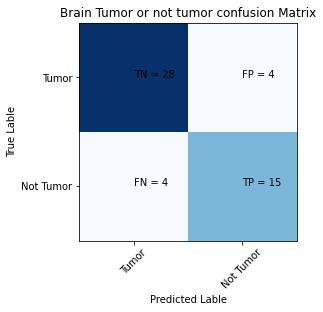

In [21]:
evaluate_model(model, X_test, y_test)